In [77]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import csv

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.model_selection import train_test_split
import sklearn.decomposition as skd

In [78]:
def get_raw_data(path):
    _filename = path + '/2D_FZ_FORMATTED.txt'
    _data = pickle.load(open(_filename, 'rb'))
    return _data

def create_dataset():    

    # Using new cases from Kalki
    _rawDataPath = "./2D_CFD_Dataset/simulation_files"
    _parameterPath = "./2D_CFD_Dataset/case_parameters.csv"
    
    _parameters = []
    # read parameters
    with open(_parameterPath) as _f:
        _csvFile = csv.reader(_f)
        next(_csvFile) # skip column names
        for _r in _csvFile:
            if _r[12] == 'Y': # case has been run
                _parameters.append([float(_i) for _i in _r[0:11]])    
    _X = []
    _Y = []

    for _param in enumerate(_parameters):
        _i = int(_param[1][0])
        _path = f'{_rawDataPath}/RUN_{_i}'
        _x,_y,_ = get_raw_data(_path)
        _X.append(_param[1][1:])
        _Y.append(_y[2000:4000])
    return np.array(_X), np.array(_Y)

def normData(x):
    _mean = np.mean(x,axis=0)
    _std = np.std(x,axis=0)
    return (x-_mean)/_std, _mean, _std

def RMSE(x,y):
    return np.sqrt(np.mean((x-y)**2))

def nonDimentionalizeF(X):
    _M = X[:,0]+X[:,1]
    _param = _M**2/np.abs(X[:,2])**3/np.sqrt(1-X[:,0]**2)
    return _param.reshape(-1,1)

def plot_compare(x,y,startN):    
    _caseN = 10
    f=plt.figure(figsize=(40,15))
    for _n in range (startN, startN+_caseN):
        ax=plt.subplot(2,5,_n+1-startN)
        plt.plot(x[_n],label='Exact')
        plt.plot(y[_n],label='GPR')
        plt.title('Case {0:1.0f}'.format(_n))
        plt.legend(loc=0)
        #plt.ylim([-5000,2000])
    plt.show()

In [79]:
# Create dataset and normalize
Xtemp, Ytemp = create_dataset()
# Select a few cases from the dataset
X = []
Y = []
for n in range(Xtemp.shape[0]):
    #if abs(Xtemp[n][4]) != 3. and Xtemp[n][0] != 5. and Xtemp[n][2] != 0.1 and Xtemp[n][3] != 0.1 and Xtemp[n][2] != 0.8 and Xtemp[n][3] != 0.8:
    if abs(Xtemp[n][4]) != 3. and Xtemp[n][0] != 5.: # eliminating cases where separation distance = 3 or AOA = 5
        X.append(Xtemp[n][2:5]) # only AOA = 0 so eliminate the first two columns
        Y.append(Ytemp[n])
X = np.array(X)
Y = np.array(Y)

# Dataset size
print (X.shape, Y.shape)
# Split dataset to training set and testing set
n_features = Y.shape[1]
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size = 0.2)
# Non-dimentionalize Y to achieve similar output magnitude among cases
NDTrain = nonDimentionalizeF(xTrain)
NDTest = nonDimentionalizeF(xTest)
yTrain = yTrain/NDTrain
yTest = yTest/NDTest
# Normalize dataset using mean&std
xTrainN, xTrainM, xTrainStd = normData(xTrain)
xTestN = (xTest - xTrainM) / xTrainStd
yTrainN, yTrainM, yTrainStd = normData(yTrain)
# PCA SKLearn
y = yTrain - np.mean(yTrain, axis=0) # Zero Mean
pca = skd.PCA(n_components=0.99)
dyn_pca = pca.fit_transform(y)
yTrainN, yTrainM, yTrainStd = normData(dyn_pca)

(96, 3) (96, 2000)


In [80]:
# Latest version of GPR, no trend function
nRestarts = 5
kernel = ConstantKernel(1.0, (1e-1,1e1)) * RBF(length_scale=np.ones(X.shape[1]), length_scale_bounds=(1e-2,1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=nRestarts).fit(xTrainN,yTrainN)

In [81]:
yPredictTraining = gp.predict(xTrainN) * yTrainStd + yTrainM
yPredictTesting = gp.predict(xTestN) * yTrainStd + yTrainM
# If trained using PCA data
yPredictTraining = pca.inverse_transform(yPredictTraining) + np.mean(yTrain,axis=0)
yPredictTesting = pca.inverse_transform(yPredictTesting) + np.mean(yTrain,axis=0)

# TODO: Error calculation needs to be modified
print ('Training RMSE = {0:2.5f}'.format(RMSE(yPredictTraining[0],yTrain[0])))
print ('Testing RMSE = {0:2.5f}'.format(RMSE(yPredictTesting[0],yTest[0])))

Training RMSE = 86.04592
Testing RMSE = 175.49600


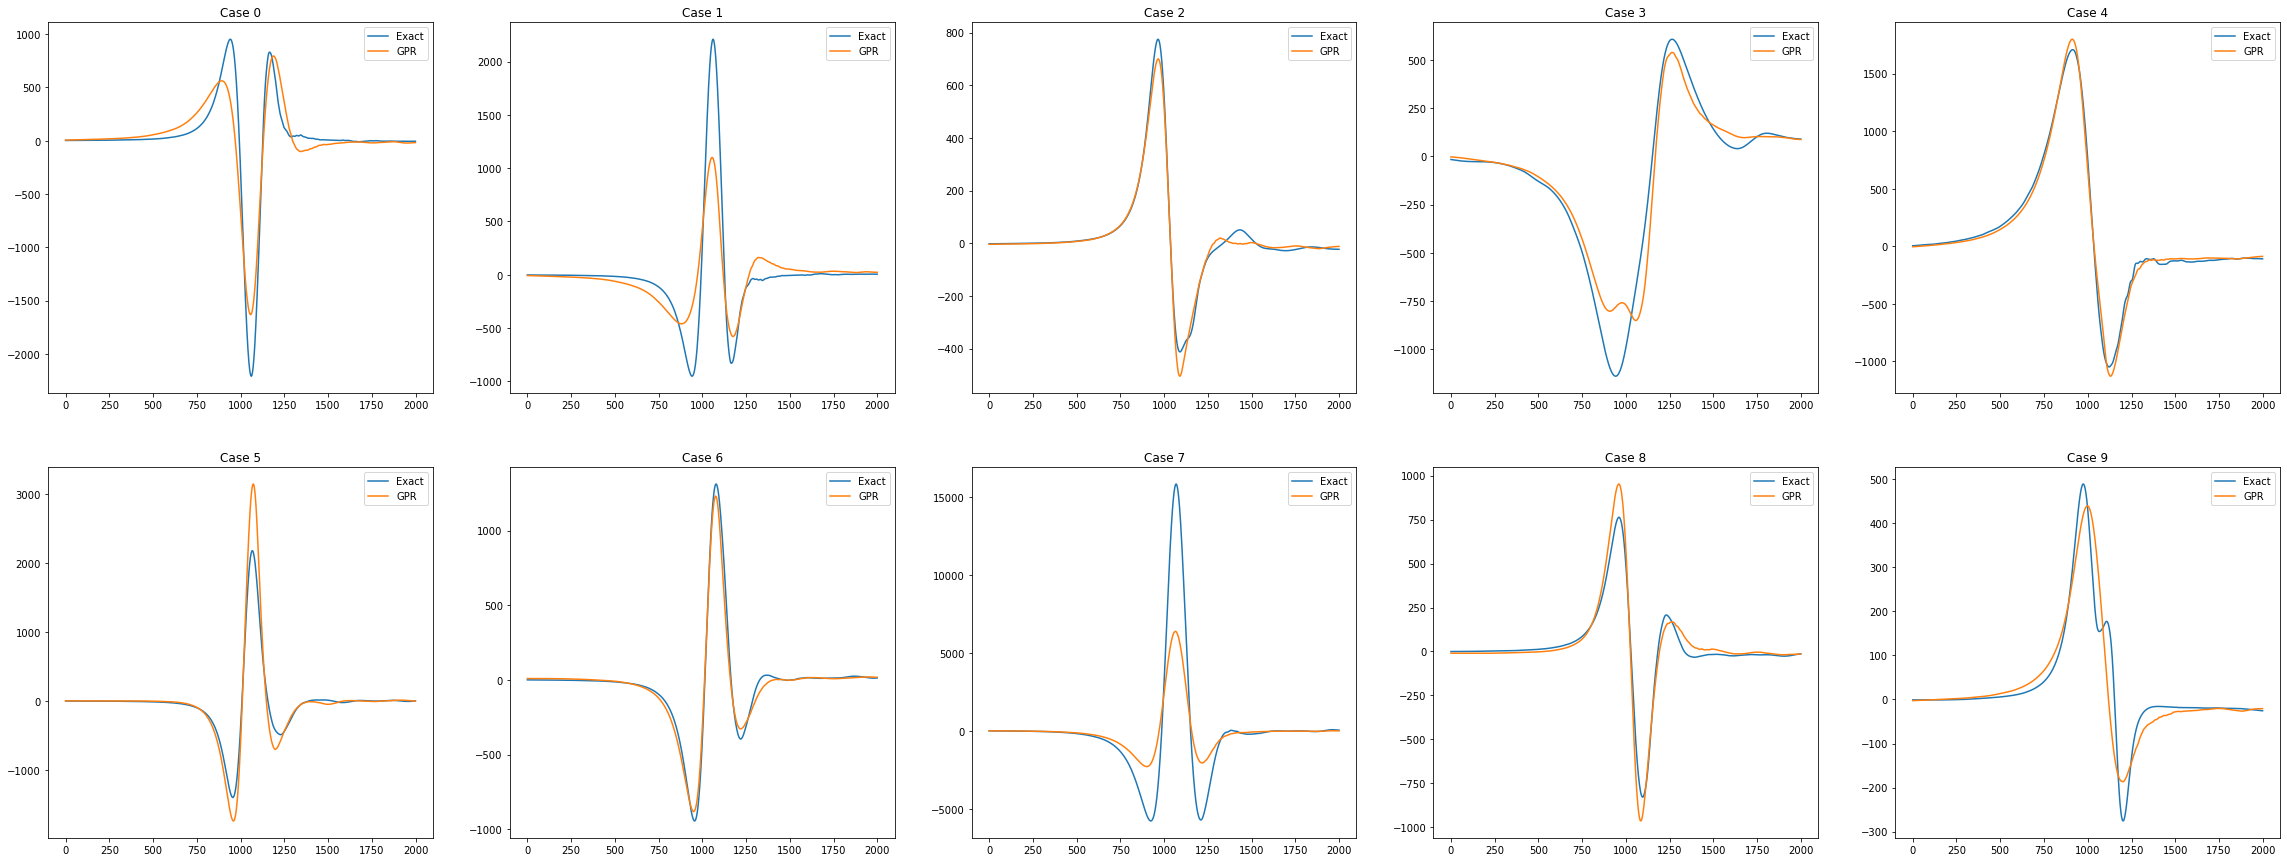

In [82]:
plot_compare(yTest,yPredictTesting,0)

In [83]:
#plot_compare(yTrain,yPredictTraining,0)

In [84]:
# Older version of GPR where trend function is still available
import oldVerGPR 

gp2 = oldVerGPR.sklGPR(theta = [0.1, 1e-6, 10.0],regr = 'linear', corr = 'matern52',noiseLvl = 1e-14) # TODO: need to compare different trend functions and kernels.
gp2.fit(xTrainN, yTrainN)


skl: Training GPR


In [85]:
yPredictTraining = gp2.predict(xTrainN,eval_MSE=False, use_lib=False) * yTrainStd + yTrainM
yPredictTesting = gp2.predict(xTestN,eval_MSE=False, use_lib=False) * yTrainStd + yTrainM
# If trained using PCA data
yPredictTraining = pca.inverse_transform(yPredictTraining) + np.mean(yTrain,axis=0)
yPredictTesting = pca.inverse_transform(yPredictTesting) + np.mean(yTrain,axis=0)

# TODO: Error calculation needs to be modified
print ('Training RMSE = {0:2.5f}'.format(RMSE(yPredictTraining[0],yTrain[0])))
print ('Testing RMSE = {0:2.5f}'.format(RMSE(yPredictTesting[0],yTest[0])))

Training RMSE = 86.04592
Testing RMSE = 157.90620


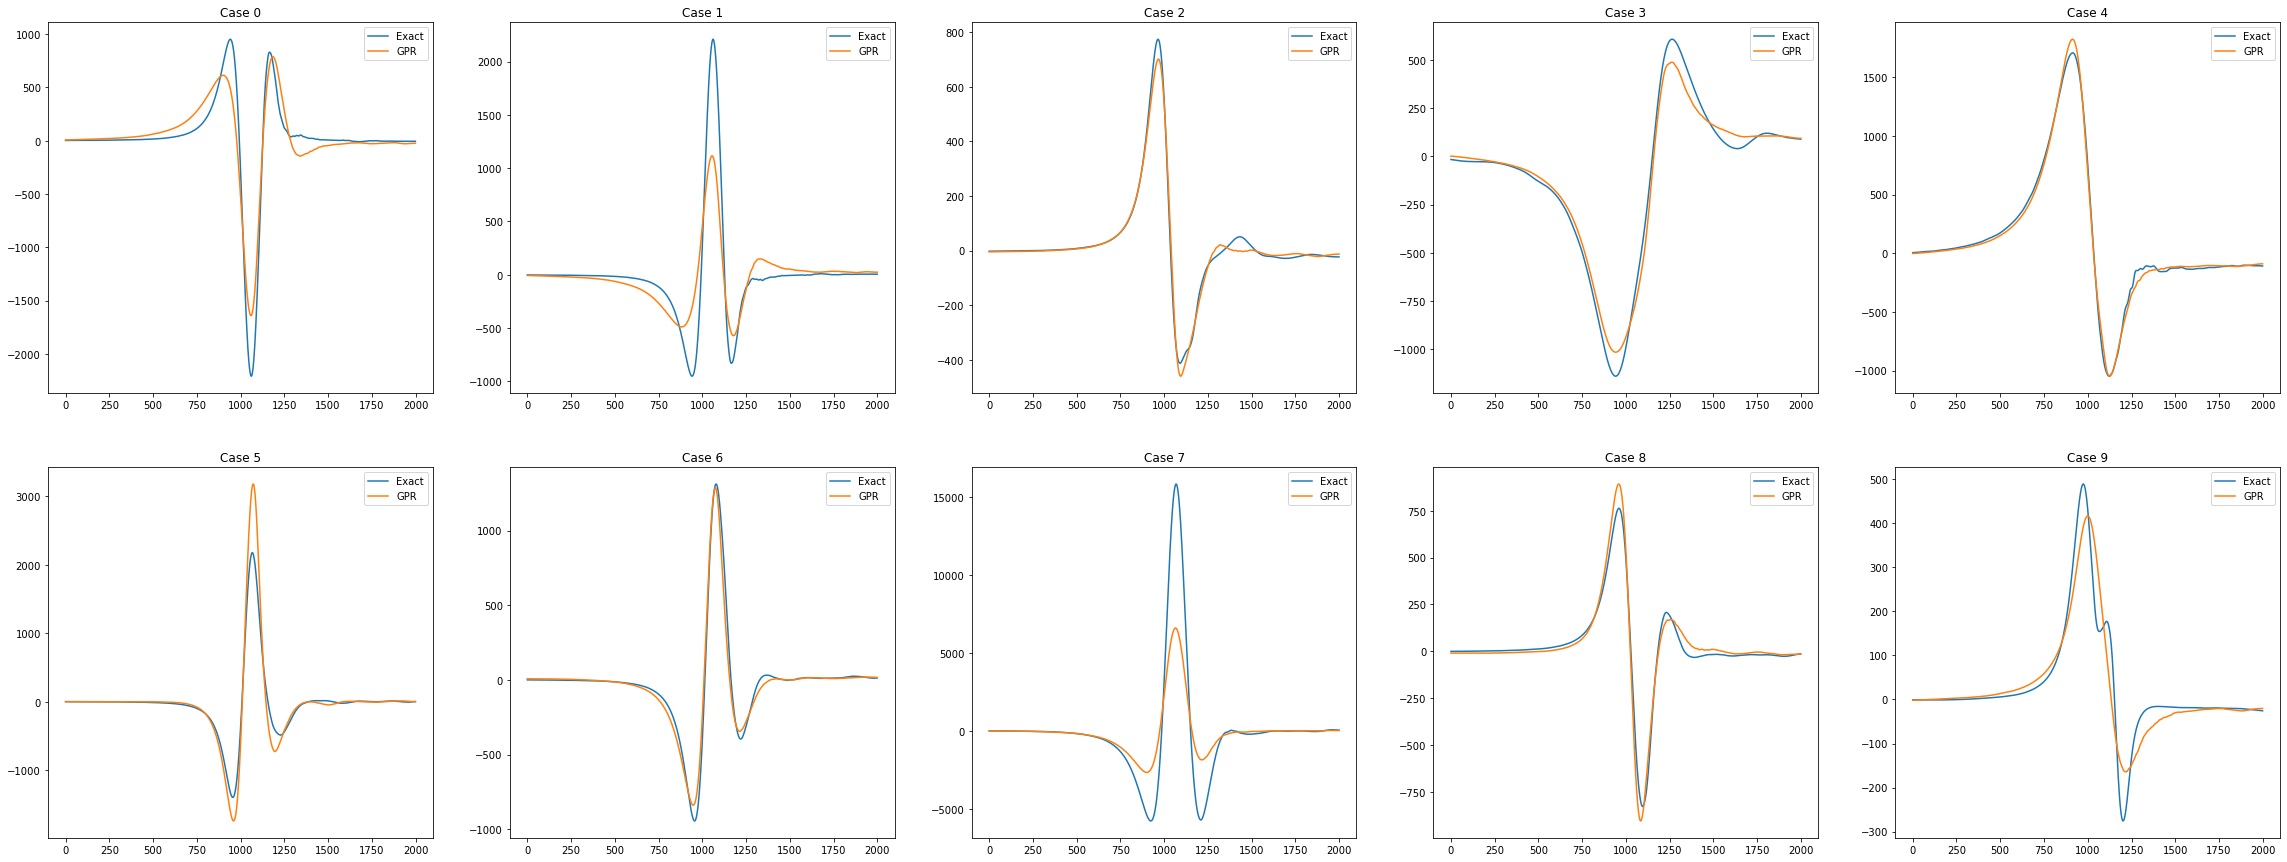

In [86]:
plot_compare(yTest,yPredictTesting,0)

In [87]:
yPredictTesting = yPredictTesting * NDTest
yTest = yTest * NDTest

In [88]:
# # Try non-dimentionalize force
# nonDimentionalize = (X[:,0]+X[:,1])**2/np.abs(X[:,2])**3
# nonDimentionalize2 = (X[:,0]+X[:,1])**2/X[:,2]**4
# # n = 0
# # f=plt.figure()
# # plt.plot(Y[n])
# # plt.plot(Y[n]/nonDimentionalize[n])
# # plt.plot(Y[n]/nonDimentionalize2[n])
# # #print (X)

# _caseN = 10
# f=plt.figure(figsize=(40,15))
# for n in range (0,10):
#     ax=plt.subplot(2,5,n+1)
#     plt.plot(Y[n],label='original')
#     plt.plot(Y[n]/nonDimentionalize[n],label='z**3')
#     plt.plot(Y[n]/nonDimentionalize2[n],label='z**4')
#     plt.title('Case {0:1.0f}'.format(n))
#     plt.legend(loc=0)
#     #plt.ylim([-5000,2000])
# plt.show()